### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.RetFound import get_retfound
from src.model import FoundationalCVModelWithClassifier
from src.FocalLoss import FocalLoss

import os
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

from src.train import train
from src.test import test


In [4]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGES = os.path.join(DATASET, 'images/')
DOWNLOAD = False
SHAPE = (224, 224)
LABEL = 'DR_ICDR'
IMAGE_COL = 'image_id'
TEST_SIZE = 0.3
UNDERSAMPLE = False

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

BACKBONE = True #'retfound'
MODE = 'fine_tune'
backbone_mode='fine_tune'

HIDDEN = 756
num_classes = 3

BATCH_SIZE = 64
NUM_WORKERS = 4


LOSS = 'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 2
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#### Read csv file:

In [5]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df.head()

loading csv file in /home/opc/Retina/BRSET//labels.csv


,image_id,patient_id,camera,patient_age,comorbidities,diabetes_time_y,insuline,patient_sex,exam_eye,diabetes,...,vascular_occlusion,hypertensive_retinopathy,drusens,hemorrhage,retinal_detachment,myopic_fundus,increased_cup_disc,other,quality,normality
0,img00001,1,Canon CR,48.0,diabetes1,12,yes,1,1,yes,...,0,0,0,0,0,0,1,0,Adequate,abnormal
1,img00002,1,Canon CR,48.0,diabetes1,12,yes,1,2,yes,...,0,0,0,0,0,0,1,0,Adequate,abnormal
2,img00003,2,Canon CR,18.0,diabetes1,7,yes,2,1,yes,...,0,0,0,0,0,0,0,0,Adequate,normal
3,img00004,2,Canon CR,18.0,diabetes1,7,yes,2,2,yes,...,0,0,0,0,0,0,0,0,Adequate,normal
4,img00005,3,Canon CR,22.0,diabetes1,11,yes,1,1,yes,...,0,0,0,0,0,0,0,0,Adequate,normal


In [6]:
# Convert into 3 classes:

# Normal = 0; Non-proliferative = 1, 2, 3; Proliferative = 4
# Map values to categories
df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0 else ('Non-proliferative' if x in [1, 2, 3] else 'Proliferative'))


Train data shape: (11386, 35)
Test data shape: (4880, 35)


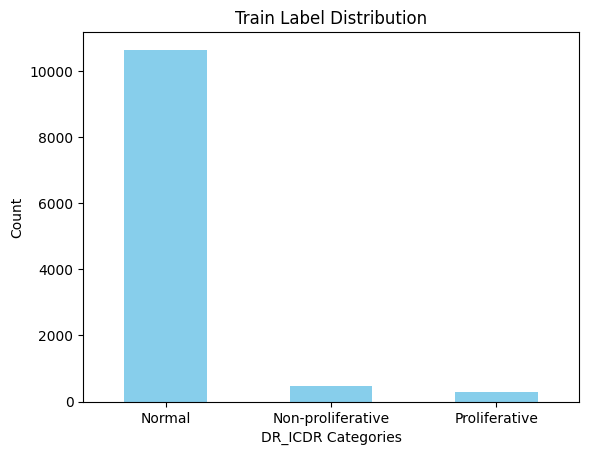

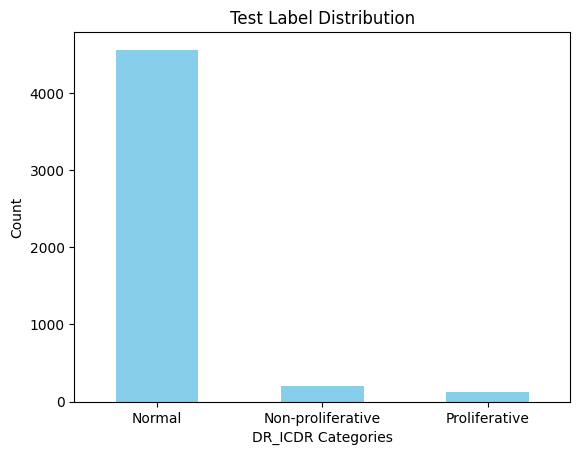

Getting validation set...
Train data shape: (10247, 35)
Test data shape: (1139, 35)


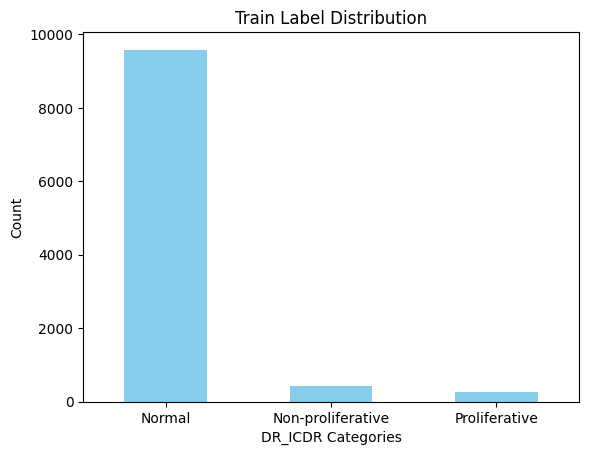

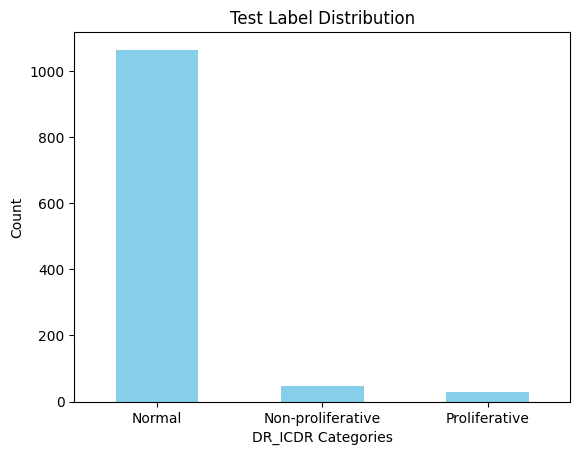

In [7]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE)
print('Getting validation set...')
df_train, df_val = split_data(df_train, LABEL, 0.1)

### Dataloaders

In [8]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [9]:
# Define the target image shape

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

In [10]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


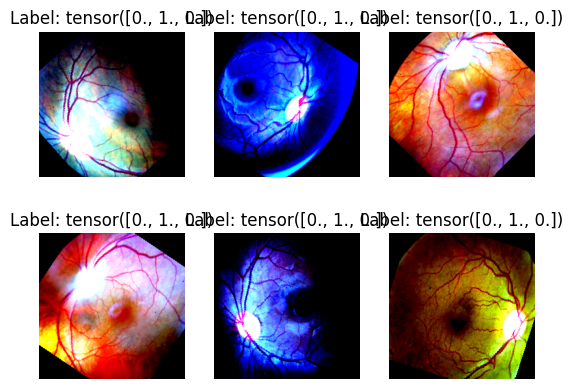

In [11]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels

for batch in train_dataloader:

    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [12]:
# Create a DataLoader to generate embeddings
backbone_model = get_retfound(backbone=BACKBONE)
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Access denied with the following error:
File 'Weights/RETFound_cfp_weights.pth' downloaded successfully.



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id={file_id} 



AttributeError: 'NoneType' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

: 

### Training:

In [9]:
if LOSS == 'focal_loss':
    criterion = FocalLoss()  # Focal Loss
else:
    criterion = nn.BCELoss()  #nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [10]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=20, save=False, device=device)

100%|██████████| 161/161 [03:12<00:00,  1.20s/it]


Epoch 1, Training Loss: 0.16679732233100797


100%|██████████| 18/18 [00:22<00:00,  1.27s/it]


Epoch 1, Validation Loss: 0.14370721578598022


100%|██████████| 161/161 [03:16<00:00,  1.22s/it]


Epoch 2, Training Loss: 0.1153639727127478


100%|██████████| 18/18 [00:22<00:00,  1.25s/it]


Epoch 2, Validation Loss: 0.18406578401724497


100%|██████████| 161/161 [03:18<00:00,  1.23s/it]


Epoch 3, Training Loss: 0.08371634369496234


100%|██████████| 18/18 [00:22<00:00,  1.27s/it]


Epoch 3, Validation Loss: 0.07763857911858293


100%|██████████| 161/161 [03:18<00:00,  1.23s/it]


Epoch 4, Training Loss: 0.07208984023573235


100%|██████████| 18/18 [00:22<00:00,  1.25s/it]


Epoch 4, Validation Loss: 4.366446468565199


100%|██████████| 161/161 [03:17<00:00,  1.23s/it]


Epoch 5, Training Loss: 0.07761893974420447


100%|██████████| 18/18 [00:22<00:00,  1.27s/it]


Epoch 5, Validation Loss: 0.07656875025067064


100%|██████████| 161/161 [03:18<00:00,  1.23s/it]


Epoch 6, Training Loss: 0.07181246568281088


100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 6, Validation Loss: 0.0738343759957287


100%|██████████| 161/161 [03:18<00:00,  1.23s/it]


Epoch 7, Training Loss: 0.06855573731919994


100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 7, Validation Loss: 0.08146550009648006


100%|██████████| 161/161 [03:17<00:00,  1.23s/it]


Epoch 8, Training Loss: 0.06687618309620375


100%|██████████| 18/18 [00:22<00:00,  1.27s/it]


Epoch 8, Validation Loss: 0.07514800089928839


100%|██████████| 161/161 [03:17<00:00,  1.22s/it]


Epoch 9, Training Loss: 0.07208163583917278


100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 9, Validation Loss: 0.08176681357953283


100%|██████████| 161/161 [03:17<00:00,  1.22s/it]


Epoch 10, Training Loss: 0.07236693936012546


100%|██████████| 18/18 [00:22<00:00,  1.25s/it]


Epoch 10, Validation Loss: 2.1686499979760914


100%|██████████| 161/161 [03:17<00:00,  1.23s/it]


Epoch 11, Training Loss: 0.06971700144758136


100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 11, Validation Loss: 0.08906540626453029


100%|██████████| 161/161 [03:18<00:00,  1.23s/it]


Epoch 12, Training Loss: 0.06519189862222034


100%|██████████| 18/18 [00:22<00:00,  1.27s/it]


Epoch 12, Validation Loss: 0.07458443091147476


100%|██████████| 161/161 [03:16<00:00,  1.22s/it]


Epoch 13, Training Loss: 0.06537614777823042


100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 13, Validation Loss: 0.07890515898664792


100%|██████████| 161/161 [03:19<00:00,  1.24s/it]


Epoch 14, Training Loss: 0.06936647261706938


100%|██████████| 18/18 [00:22<00:00,  1.25s/it]


Epoch 14, Validation Loss: 0.0923894341621134


100%|██████████| 161/161 [03:18<00:00,  1.23s/it]


Epoch 15, Training Loss: 0.06400156464219464


100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 15, Validation Loss: 0.07497946669658025


100%|██████████| 161/161 [03:17<00:00,  1.23s/it]


Epoch 16, Training Loss: 0.0632156142444344


100%|██████████| 18/18 [00:22<00:00,  1.27s/it]


Epoch 16, Validation Loss: 0.07767369370493624


100%|██████████| 161/161 [03:16<00:00,  1.22s/it]


Epoch 17, Training Loss: 0.07438598469084834


100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 17, Validation Loss: 0.0766150417427222


100%|██████████| 161/161 [03:17<00:00,  1.22s/it]


Epoch 18, Training Loss: 0.07012419633983825


100%|██████████| 18/18 [00:22<00:00,  1.25s/it]


Epoch 18, Validation Loss: 0.07741118243171109


100%|██████████| 161/161 [03:17<00:00,  1.23s/it]


Epoch 19, Training Loss: 0.06736883127726383


100%|██████████| 18/18 [00:22<00:00,  1.25s/it]


Epoch 19, Validation Loss: 0.08404627690712611


 80%|███████▉  | 128/161 [02:39<00:37,  1.15s/it]

### Test

In [ ]:
test(model, test_dataloader, saliency=True, device=device)

Accuracy on test images: 71.91780821917808%
AUC: 0.7191780821917808
F1 Score: 0.7296703296703297
